# Notebook to experiment with the environment created

-------------------
https://gymnasium.farama.org/api/env/

“human”: The environment is continuously rendered in the current display or terminal, usually for human consumption. This rendering should occur during step() and render() doesn’t need to be called. Returns None.

“rgb_array”: Return a single frame representing the current state of the environment. A frame is a np.ndarray with shape (x, y, 3) representing RGB values for an x-by-y pixel image.

“ansi”: Return a strings (str) or StringIO.StringIO containing a terminal-style text representation for each time step. The text can include newlines and ANSI escape sequences (e.g. for colors).

--------------------

https://gymnasium.farama.org/api/spaces/

Box - Supports continuous (and discrete) vectors or matrices, used for vector observations, images, etc

Discrete - Supports a single discrete number of values with an optional start for the values

MultiBinary - Supports single or matrices of binary values, used for holding down a button or if an agent has an object

MultiDiscrete - Supports multiple discrete values with multiple axes, used for controller actions

Text - Supports strings, used for passing agent messages, mission details, etc

-------------------

_ means non public part of API

If you do not normalize images, you need to decrease the learning rate accordingly, as weight updates will be '255' (as an example) times higher than if you normalize the data.

Data normalization keeps weight updates small, helping 'gradient descent' (any optimizer is a different gradient descent at the end) not jump between minimums.

Moreover, the MRI scans all have different intensity ranges

----------------------

uint8 -> unsigned integers, 8 bits, grayscale/color images [0-255]

float32 / float64 -> float with one or double precision. in images, it's usually [0.0-1.0]


| Where                                      | Why                              | dtype           |
| ------------------------------------------ | ---------------------------------| --------------- |
| `self.image`                               | continuous, floats               | `float32`       |
| `self.mask`                                | binary                           | `uint8`         |
| `vis_img / vis_img.max()`                  | normalization for plotting       | `float32`       |
| `overlay[..., 0] = (mask>0).astype(float)` | blend needs floats               | temporary float |
| `(1-alpha)*A + alpha*B`                    | alpha blending (needs fractions) | float math      |

(taula del chat)

-----------------------


## Code:

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Glioblastoma environemnt

<span style="color:red">Init</span>

- image and mask
- grid (4x4 cells. each of 60x60 pixels)
- render mode

- action space: discrete of 3 actions - stay, down, right
- observation space: 

- initial position and counter of steps as well as max episode length

<span style="color:red">Reset</span>

- Get everything to 0

<span style="color:red">step</span>

1. read action
2. update step counter
3. move self.agent_pos matrix
4. get reward and observation
5. see if episode ended (step counter >= episode max)

<span style="color:red">get obss</span>

1. Get the self.agent_pos number of both the row and the column
2. multiply by block size (60) to get the pixel
3. return that patch where i am right now

<span style="color:red">get reward</span>

1. see position of my agent in the mask
2. see if we are in a tumor cell (THRESHOLD OF 0.15) FALTA MIRAR SI ES POT FER AIXO
3. give reward accordingly 

<span style="color:red">render</span>

1. create RGB image
2. create overlay
3. plot with
    1. grid lines
    2. position

<span style="color:red">Falta mirar</span>

- reward -1?




In [3]:
class Glioblastoma(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4} 
    # The metadata of the environment, e.g. {“render_modes”: [“rgb_array”, “human”], “render_fps”: 30}. 
    # For Jax or Torch, this can be indicated to users with “jax”=True or “torch”=True.

    def __init__(self, image_path, mask_path, grid_size=4, tumor_threshold=0.15, render_mode="human"): # cosntructor with the brain image, the mask and a size
        super().__init__() # parent class
        
        self.image = np.load(image_path).astype(np.float32)
        self.mask = np.load(mask_path).astype(np.uint8)
        
        img_min, img_max = self.image.min(), self.image.max()
        if img_max > 1.0:  # only normalize if not already in [0, 1]
            self.image = (self.image - img_min) / (img_max - img_min + 1e-8) #avoid division by 0

        self.grid_size = grid_size
        self.block_size = self.image.shape[0] // grid_size  # 240/4 = 60
        self.render_mode = render_mode

        # Define action and observation spaces
        # Actions: 0 = stay, 1 = move down, 2 = move right
        self.action_space = spaces.Discrete(3)

        # Observations: grayscale patch (normalized 0-1)
        # apparently Neural networks train better when inputs are scaled to small, 
        # consistent ranges rather than raw 0–255 values.
        self.observation_space = spaces.Box( # Supports continuous (and discrete) vectors or matrices
            low=0, high=1, # Data has been normalized
            shape=(self.block_size, self.block_size), # shape of the observation
            dtype=np.float32
        )

        self.agent_pos = [0, 0] # INITIAL POSITION AT TOP LEFT
        self.current_step = 0 # initialize counter
        self.max_steps = 20  # like in the paper

        self.tumor_threshold = tumor_threshold # 15% of the patch must be tumor to consider that the agent is inside the tumor region

    def reset(self, seed=None, options=None): # new episode where we initialize the state. 
        super().reset(seed=seed) # parent
        
        # reset
        self.agent_pos = [0, 0]  # top-left corner
        self.current_step = 0
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1

        prev_pos = self.agent_pos.copy() # for reward computation taking into consideration the transition changes
        
        # Apply action (respect grid boundaries)
        if action == 1 and self.agent_pos[0] < self.grid_size - 1:
            self.agent_pos[0] += 1  # move down
        elif action == 2 and self.agent_pos[1] < self.grid_size - 1:
            self.agent_pos[1] += 1  # move right
        # else, the agent doesn't move so the observation 
        # and reward will be calculated from the same position
        # no need to compute self.agent_po

        reward = self._get_reward(action, prev_pos)
        obs = self._get_obs()

        # Episode ends
        terminated = self.current_step >= self.max_steps
        truncated = False  # we don’t need truncation here
        info = {}

        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        r0 = self.agent_pos[0] * self.block_size # row start
        c0 = self.agent_pos[1] * self.block_size # col start
        
        patch = self.image[r0:r0+self.block_size, c0:c0+self.block_size]
        return patch.astype(np.float32) #just to ensure everything is float32

    def _get_reward(self, action, prev_pos):
        # look for previous position in the mask
        r0_prev = prev_pos[0] * self.block_size
        c0_prev = prev_pos[1] * self.block_size
        patch_mask_prev = self.mask[r0_prev:r0_prev+self.block_size, c0_prev:c0_prev+self.block_size]
        
        # look position of the agent in the mask
        r0 = self.agent_pos[0] * self.block_size
        c0 = self.agent_pos[1] * self.block_size
        patch_mask = self.mask[r0:r0+self.block_size, c0:c0+self.block_size]
        
        # Now that i have the patch where i was and the patch where i am, i can check if there is tumor in any of them
        # tumor is labeled as 1 or 4 in the mask        
        # label 2 is edema
        
        # first get a count of the tumor pixels in the patch. 
        tumor_count_prev = np.sum(np.isin(patch_mask_prev, [1, 4]))
        tumor_count_curr = np.sum(np.isin(patch_mask, [1, 4]))

        # Determine if patch has more than self.tumor_threshold of tumor
        was_inside = tumor_count_prev > self.tumor_threshold
        inside = tumor_count_curr > self.tumor_threshold

        # REWARD STRATEGY DELS DEL PAPER FALTA SI AIXO ES AIXI
        if inside: # regardless of previous position
            print("Entered tumor region!") # DEBUGGING ONLY!
            return 1.0  # entered tumor region
        if not was_inside and not inside: # still outside
            if action == 0: # didn't move
                return -2.0
            else:
                return -0.5 # moved but still outside
        if was_inside and not inside: # exited tumor region
            print("Exited tumor region!") # DEBUGGING ONLY!
            return -0.5  # exited tumor region #maybe should be -1.0? FALTAA!!!!!!!!!!!!!!!!!!!1
        return 0.0

    def render(self):
        if self.render_mode != "human": # would be rgb_array or ansi
            return  # Only render in human mode

        # Create RGB visualization image
        # not necessary since it's grayscale, but i want to draw the mask and position
        vis_img = np.stack([self.image] * 3, axis=-1).astype(np.float32)

        # Overlay tumor mask in red [..., 0] 
        tumor_overlay = np.zeros_like(vis_img) # do all blank but here we have 3 channels, mask is 2D
        tumor_overlay[..., 0] = (self.mask > 0).astype(float) # red channel. set to float to avoid issues when blending in vis_img

        # transparency overlay (crec que es el mateix valor que tinc a l'altra notebook)
        alpha = 0.4
        vis_img = (1 - alpha) * vis_img + alpha * tumor_overlay

        # Plotting
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(vis_img, cmap='gray', origin='upper')

        # Draw grid lines
        # alpha for transparency again
        for i in range(1, self.grid_size):
            ax.axhline(i * self.block_size, color='white', lw=1, alpha=0.5)
            ax.axvline(i * self.block_size, color='white', lw=1, alpha=0.5)

        # Draw agent position
        r0 = self.agent_pos[0] * self.block_size
        c0 = self.agent_pos[1] * self.block_size
        rect = patches.Rectangle(
            (c0, r0), # (x,y) bottom left corner
            self.block_size, # width
            self.block_size, # height
            linewidth=2,
            edgecolor='yellow',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.set_title(f"Agent at {self.agent_pos} | Step {self.current_step}")
        ax.axis('off')
        plt.show()


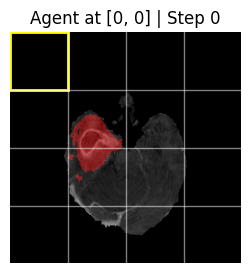

Reward: -2.0


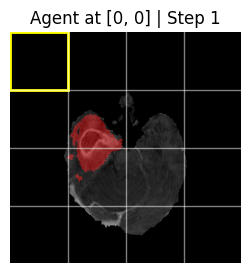

Reward: -0.5


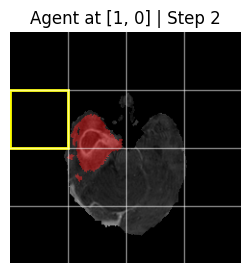

Reward: -0.5


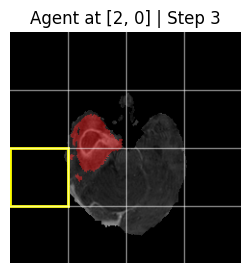

Entered tumor region!
Reward: 1.0


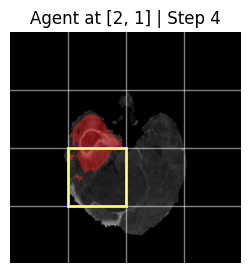

ValueError: invalid literal for int() with base 10: ''

In [4]:
# implement function to play by hand:
def play_manual(name):
    trial_image_path = f"/home/martina/codi2/4year/tfg/training_set_npy/{name}.npy"
    trial_mask_path = f"/home/martina/codi2/4year/tfg/training_set_npy/{name}_mask.npy"

    env = Glioblastoma(trial_image_path, trial_mask_path, grid_size=4, render_mode="human")
    
    obs, info = env.reset()
    done = False
    while not done:
        env.render()
        action = int(input("Enter action (0=stay, 1=down, 2=right): "))
        obs, reward, done, trunc, info = env.step(action)
        print(f"Reward: {reward}")
    print("Episode finished.")

name = '001_49'
play_manual(name)